In [262]:
%matplotlib inline
import torch
import math
import time
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')

这行代码 ```%matplotlib inline``` 是 Jupyter Notebook 或 JupyterLab 中的一个魔术命令，用于指示 Notebook 在单元格中直接显示 Matplotlib 绘制的图形，而不是弹出一个新窗口显示图形。这使得图形能够直接嵌入到 Notebooks 中，并且在导出 Notebook 时也能够保留图形。

# 线性神经网路

## 线性回归

### 矢量化加速
    这个非常重要

In [263]:
# 定义一个计时器
class Timer:
    '''记录多次运行的时间'''
    def __init__(self) -> None:
        self.times = []
        # 从定义这个计时器就开始计时
        self.start()
        
    def start(self):
        '''启动计时器'''
        self.tik = time.time()

    def stop(self):
        '''停止计时器并将时间记录在列表中'''
        self.times.append(time.time() - self.tik)
        return self.times[-1]
    
    def avg(self):
        '''返回平均时间'''
        return sum(self.times) / len(self.times)
    
    def sum(self):
        '''返回时间总和'''
        return sum(self.times)
    
    def cumsum(self):
        '''返回累计时间'''
        return np.array(self.times).cumsum().tolist()


In [288]:
n = 10000
a = torch.ones([n])
b = torch.ones([n])

timer = Timer()
c = torch.zeros(n)
for i in range(n):
    c[i] = a[i] + b[i]
print(f'遍历的方法：{timer.stop():.6f} sec')

timer.start()
d = a + b
print(f'矢量化方法：{timer.stop():.6f} sec')

遍历的方法：0.091999 sec
矢量化方法：0.000000 sec


### 正态分布与平方损失

In [289]:
# 定义一个正态分布
def normal(x, mu, sigma):
    '''正太分布密度函数'''
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 / sigma**2 * (x - mu)**2)

## 线性回归从0开始

In [290]:
import random 
import torch
from d2l import torch as d2l

### 1.生成数据

In [291]:
def synthetic_data(w, b, num_examples):  #@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    # matmul将X与w相乘
    y = torch.matmul(X, w) + b
    # 向生成的数据中加入随机扰动项
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

# 生成数据
true_w = torch.tensor([2, -3.4, 3])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

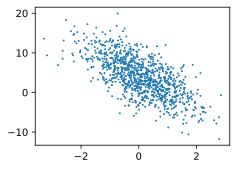

In [292]:
# 绘制图像
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1)

### 2.读取数据集

In [293]:
def data_iter(batch_size, features, labels):
    '''生成小批量'''
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break  # 只输出一个看看

tensor([[-0.7332, -0.2008,  1.5912],
        [-0.6484, -0.5016, -0.4312],
        [ 0.7357, -0.2615, -0.9216],
        [ 0.7186,  0.8968,  0.3928],
        [-0.2369,  0.9334, -1.3084],
        [-0.4124, -1.1869,  0.5455],
        [ 0.2955,  1.0181,  1.4953],
        [-0.7743, -0.8221, -0.5693],
        [-1.1232,  1.7204, -2.2294],
        [ 0.2867,  0.7038, -1.3647]]) 
 tensor([[  8.2049],
        [  3.3311],
        [  3.7953],
        [  3.7578],
        [ -3.3878],
        [  9.0507],
        [  5.8156],
        [  3.7322],
        [-10.5811],
        [ -1.7205]])


### 3.初始化模型参数

In [307]:
# 初始化权重
w = torch.normal(0, 0.01, size=(3,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
w, b

(tensor([[-0.0009],
         [ 0.0072],
         [ 0.0009]], requires_grad=True),
 tensor([0.], requires_grad=True))

### 4.定义模型

In [295]:
def linreg(X, w, b):
    '''线性回归模型'''
    return torch.matmul(X, w) + b

### 5.定义损失函数

In [296]:
def squared_loss(y_hat, y):
    '''均方损失'''
    # y_hat是预测值
    return (y_hat - y.reshape(y_hat.shape)) ** 2/2

### 6.定义优化算法

In [297]:
# 这里使用的是小批量随机梯度下降
def sgd(params, lr, batch_size):
    '''小批量随机梯度下降'''
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

### 7.训练

In [309]:
lr = 0.03
num_epochs = 10
# 下面这样设置形式，后面方便换成需要的模型
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)
        l.sum().backward()
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch:{epoch + 1}, loss:{float(train_l.mean()):f}')

epoch:1, loss:0.059585
epoch:2, loss:0.000251
epoch:3, loss:0.000053
epoch:4, loss:0.000052
epoch:5, loss:0.000052
epoch:6, loss:0.000052
epoch:7, loss:0.000052
epoch:8, loss:0.000052
epoch:9, loss:0.000052
epoch:10, loss:0.000052


In [305]:
w, b

(tensor([[-0.0083],
         [ 0.0034],
         [ 0.0023]], requires_grad=True),
 tensor([0.], requires_grad=True))

## 线性回归的简洁实现

In [276]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

### 1.生成数据集

In [277]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

### 2.读取数据集

In [278]:
def load_array(data_arrays, batch_size, is_train=True):
    '''构造一个pytorch迭代器'''
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

# 读取并打印第一个小批量样本
next(iter(data_iter))

[tensor([[-0.5363, -0.4597],
         [-0.1202,  0.6134],
         [ 0.5044,  0.4125],
         [ 0.5415, -1.5571],
         [-2.2552, -0.4935],
         [-0.7582, -1.5150],
         [ 1.1533,  0.7521],
         [-1.1576, -0.6614],
         [-0.1013,  0.0677],
         [-2.2032, -0.1130]]),
 tensor([[ 4.6806],
         [ 1.8855],
         [ 3.8214],
         [10.5771],
         [ 1.3511],
         [ 7.8218],
         [ 3.9583],
         [ 4.1602],
         [ 3.7633],
         [ 0.1821]])]

### 3.定义模型

In [279]:
from torch import nn

In [280]:
net = nn.Sequential(nn.Linear(2,1))

### 4.初始化模型参数

In [281]:
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

### 5.定义损失函数

In [282]:
loss = nn.MSELoss()

### 6.定义优化算法

In [283]:
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

### 7.训练

In [284]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X), y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch:{epoch + 1}, loss:{l:f}')

epoch:1, loss:0.000214
epoch:2, loss:0.000103
epoch:3, loss:0.000103


In [285]:
w = net[0].weight.data
b = net[0].bias.data
w, b

(tensor([[ 2.0003, -3.4003]]), tensor([4.1998]))

# Q and A

1. 